In [5]:
# imports
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

# hyperparameters
batch_size  = 64
n_channels  = 3
latent_size = 256
dataset = 'cifar10'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cuda device


In [6]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# you may use cifar10 or stl10 datasets
if dataset == 'cifar10':
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10('drive/My Drive/training/cifar10', train=True, download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])),
        shuffle=True, batch_size=batch_size, drop_last=True
    )
    class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# stl10 has larger images which are much slower to train on. You should develop your method with CIFAR-10 before experimenting with STL-10
if dataset == 'stl10':
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.STL10('drive/My Drive/training/stl10', split='train+unlabeled', download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])),
    shuffle=True, batch_size=batch_size, drop_last=True)
    train_iterator = iter(cycle(train_loader))
    class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'] # these are slightly different to CIFAR-10

train_iterator = iter(cycle(train_loader))

100%|████████████████████████████████████████████████████████████████████████| 170498071/170498071 [01:58<00:00, 1442270.47it/s]


Extracting drive/My Drive/training/cifar10/cifar-10-python.tar.gz to drive/My Drive/training/cifar10


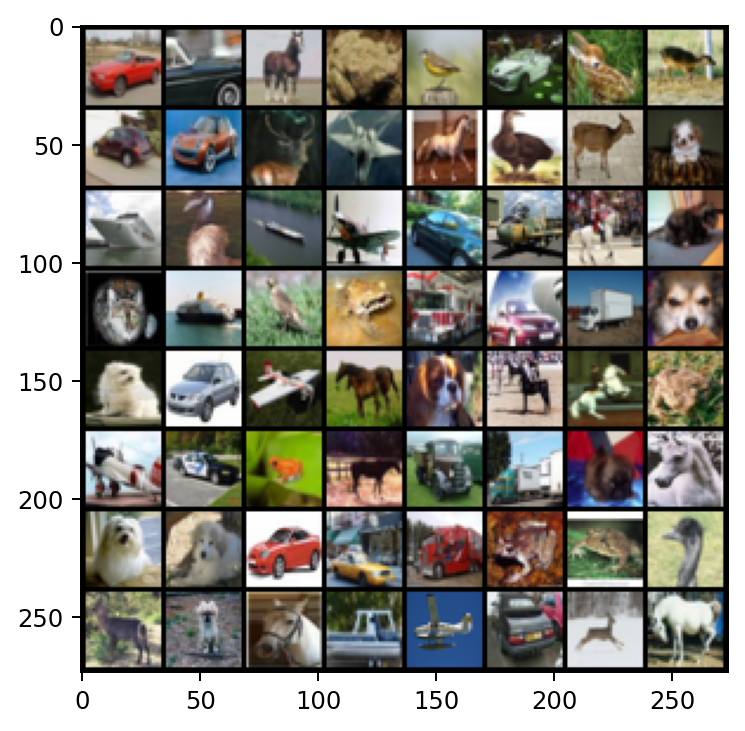

In [7]:
# let's view some of the training data
plt.rcParams['figure.dpi'] = 175
x,t = next(train_iterator)
x,t = x.to(device), t.to(device)
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(x).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

### Noise Sampling

In [8]:
def generateNoise():
    return torch.randn((batch_size, latent_size, 1, 1))

### Lightweight Generative Adversarial Network

#### Generator
The generator code is based on the flow diagram from the original paper:
<img src="generator-flow.png"> <br>
The generator model splits into 5 blocks <br>
[1] G_In -> The first block of after the noise generation (Black arrows from input) <br>
[2] G_Upscale -> A block for upscaling in each layer (Blue arrows) <br>
[3] G_SLE -> The skip_layer excitation block <br>
[4] G_Out -> The last block of the model, it outputs images (Black arrow at the last) <br>
[5] Generator -> Final BOSS -> the whole thing, built by [1] - [4], based on the structure of the flow diagram. <br>

In [ ]:
class G_In(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.In = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c*2, kernel_size=4, stride=1, padding=0), # Leave the output channel the same size as the input one cuz GLU will half it later on
            nn.BatchNorm2d(out_c*2),
            nn.GLU(dim=1),
        )

    def forward(self, x):
        # x is the random noise
        return self.In(x)


class G_Upscale(nn.Module):
    # in_c = input channel
    # out_c = output channel
    def __init__(self, in_c, out_c):
        super().__init__()
        self.upscale = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_c, out_c*2, kernel_size=3, stride=1, padding=1), # out_c* 2 -> make sure the output channel has the same size after GLU 
            nn.BatchNorm2d(out_c*2),
            nn.GLU(dim=1),
        )
        
    def forward(self, x):
        return self.upscale(x)

    
class G_SLE(nn.Module):
    # in_c_high = input of the channels of the higher resolution image
    # in_c_low = input of the channels of the lower resolution image
    def __init__(self, in_c_high, in_c_low): 
        super().__init__()
        self.sle = nn.Sequential(
            nn.AdaptiveAvgPool2d((4,4)),
            nn.Conv2d(in_c_low, in_c_low, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_c_high, in_c_low, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid(),
        )

    def forward(self, x_high, x_low):
        out = x_high * self.sle(x_low)
        return out

class G_Out(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        self.Out = nn.Sequential(
            nn.Conv2d(in_c, n_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
        )
    def forward(self, x):
        return seld.Out(x)

# index         0    1    2    3    4    5   6    7   8    9
# layer         1    4    8    16   32   64  128  256 512 1024
c        =    [256, 512, 512, 512, 512, 256, 128, 64, 32, 16, 3]
class Generator(nn.Module):
    # in_channels is a list which stores the in channel for each 
    def __init__(self, c):
        super().__init__()
        self.upTo8 = nn.Sequential(
            # get 4 x 4
            G_In(c[0], c[1]),
            # get 8 x 8
            G_Upscale(c[1], c[2]),
        )
        self.gen = nn.ModuleList([
            # get 16 x 16
            G_Upscale(c[2], c[3]),
            # get 32 x 32
            G_Upscale(c[3], c[4]),
            # get 64 x 64
            G_Upscale(c[4], c[5]),
            # get 128 x 128
            G_Upscale(c[5], c[6]),
            # get 256 x 256
            G_Upscale(c[6], c[7]),
            # get 512 x 512
            G_Upscale(c[7], c[8]),
            # get 1024 x 1024
            G_Upscale(c[8], c[9]),
        ])
        
        self.sles = nn.ModuleList([
            # first sle (8 x 128)
            G_SLE(c[6], c[2]),
            # second sle (16 x 256)
            G_SLE(c[7], c[3]),
            # third sle (32 x 512)
            G_SLE(c[8], c[4]),
        ])
        
        self.last = nn.Sequential(
            G_Out(c[9]),
        )
        
    
    def forward(self, x):
        l_8 = self.upTo8(x)
        l_16 = self.gen[0](l_8)
        l_32 = self.gen[0](l_16)
        l_64 = self.gen[0](l_32)
        l_128 = self.gen[0](l_64)
        l_256 = self.gen(self.sles[0](l_128, l_8))
        l_512 = self.gen(self.sles[0](l_256, l_32))
        l_1024 = self.gen(self.sles[0](l_512, l_32))
        out = G_Out(l_1024)
        
        return out
        

#### Discriminator
<img src="discriminator-flow.png"> <br>

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.decode = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_c, out_c*2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c*2),
            nn.GLU(dim=1),
        )

    def forward(self, x):
        return self.decode(x)
    
class D_In(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.In = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_c, out_c, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(),
        )
    def forward(self, img):
        return self.In(img)

In [ ]:
# training loop, you will want to train for more than 10 here!
while (epoch<10):
    
    # array(s) for the performance measures
    loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(100):

        # sample x from the dataset
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)

        # do the forward pass with mean squared error
        z = A.encode(x)
        x_hat = A.decode(z)
        loss = ((x-x_hat)**2).mean()

        # backpropagate to compute the gradient of the loss w.r.t the parameters and optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        # collect stats
        loss_arr = np.append(loss_arr, loss.item())

    # sample your model (autoencoders are not good at this)
    z = torch.randn_like(z)
    g = A.decode(z)

    # plot some examples
    print('loss ' + str(loss.mean()))
    plt.rcParams['figure.dpi'] = 100
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(g[:8]).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.show()
    plt.pause(0.0001)

    epoch = epoch+1

In [ ]:
# now show a batch of data for the submission, right click and save the image for your report
plt.rcParams['figure.dpi'] = 175
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

In [ ]:
# now show some interpolations (note you do not have to do linear interpolations as shown here, you can do non-linear or gradient-based interpolation if you wish)
col_size = int(np.sqrt(batch_size))

z0 = z[0:col_size].repeat(col_size,1,1,1) # z for top row
z1 = z[batch_size-col_size:].repeat(col_size,1,1,1) # z for bottom row

t = torch.linspace(0,1,col_size).unsqueeze(1).repeat(1,col_size).view(batch_size,1,1,1).to(device)

lerp_z = (1-t)*z0 + t*z1 # linearly interpolate between two points in the latent space
lerp_g = A.decode(lerp_z) # sample the model at the resulting interpolated latents

plt.rcParams['figure.dpi'] = 175
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(lerp_g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

In [ ]:
# optional example code to save your training progress for resuming later
torch.save({'A':A.state_dict(), 'optimiser':optimiser.state_dict(), 'epoch':epoch}, 'drive/My Drive/training/save.chkpt')

In [ ]:
# optional example to resume training later
params = torch.load('drive/My Drive/training/save.chkpt')
A.load_state_dict(params['A'])
optimiser.load_state_dict(params['optimiser'])
epoch = params['epoch']